In [59]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from DataProcessor import DataProcessor
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler

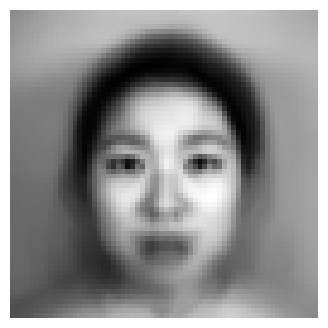

In [60]:
current_directory = os.getcwd()
image_processor = DataProcessor(current_directory)
image_processor.load_images()
image_processor.calculate_mean_image()

In [61]:
dataset = image_processor.data
images = np.array([list(img) for img in dataset['Image']])

In [63]:
labels = dataset['Expression']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [64]:
X, y = images, labels
def data_whitening(X):
    mean = np.mean(X, axis=0)
    X = X - mean
    std = np.std(X, axis=0)
    X = X / std
    return X

In [65]:
X_standardized = data_whitening(X)

In [66]:
def within_scatter(X):
    Sw = np.zeros((X.shape[1], X.shape[1]))
    for i in np.unique(y):
        Xi = X[y == i]
        mean_class = np.mean(Xi, axis=0)
        Si = np.cov(Xi, rowvar=False, bias=True) * (len(Xi) - 1)
        Sw += Si
    return Sw

In [67]:
Sw = within_scatter(X_standardized)

In [68]:
mean_overall = np.mean(X_standardized, axis=0)

In [69]:
def between_scatter(X):
    Sb = np.cov(X, rowvar=False, bias=True) * (len(X) - 1) - Sw
    return Sb

In [70]:
Sb = between_scatter(X_standardized)

In [76]:
# Compute the eigenvalues and eigenvectors of inv(Sw) * Sb
def decompose_Sw_1Sb(Sw,Sb):
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(Sw).dot(Sb))
    eigenvectors = eigenvectors.T
    idxs = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idxs]
    eigenvectors = eigenvectors[idxs]
    return eigenvectors, eigenvalues

In [77]:
eigenvectors, eigenvalues = decompose_Sw_1Sb(Sw,Sb)

In [90]:
image_size = (64,64)
num_components = 2
components = np.real(eigenvectors[0:num_components])
eigenfaces = components.reshape((num_components, *image_size))

In [91]:
def plot_eigenfaces(eigenfaces):
    num_eigenfaces = len(eigenfaces)
    num_rows = int(np.ceil(num_eigenfaces / 5))
    num_columns = min(5, num_eigenfaces)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_eigenfaces:
                ax = axes[i, j] if num_rows > 1 else axes[j]
                ax.imshow(eigenfaces[index], cmap='gray')
                ax.axis('off')

    plt.show()

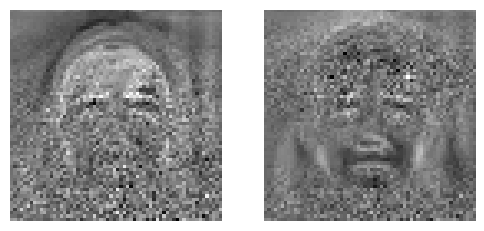

In [92]:
plot_eigenfaces(eigenfaces)

In [93]:
def plot_inverse_transformation(reconstructed_images, unique_classes, image_size):
    print("inverse transform images: ")
    fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))
    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(labels == class_label)[0]
        random_index = np.random.choice(class_indices)
        original_image = images[random_index].reshape(image_size)
        reconstructed_image = reconstructed_images[random_index]

        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Class {class_label} - Original')

        axes[1,i].imshow(reconstructed_image, cmap='gray')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Class {class_label} - Reconstructed')

    plt.tight_layout()
    plt.show()

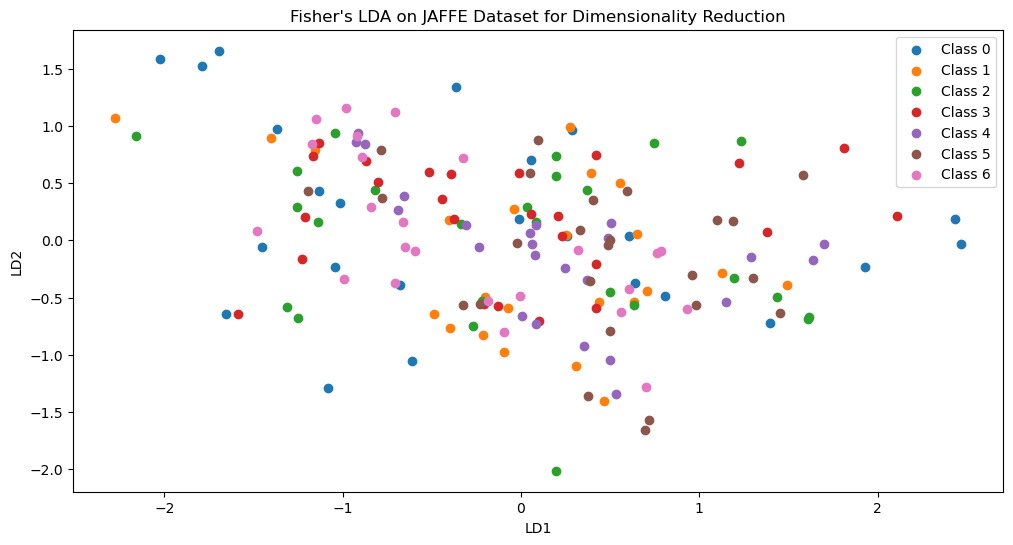

In [94]:
num_components = 2
W = eigenvectors[:, :num_components]
X_lda = X_standardized.dot(W)

plt.figure(figsize=(12, 6))

for i in np.unique(y):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], label=f'Class {i}')

plt.title('Fisher\'s LDA on JAFFE Dataset for Dimensionality Reduction')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()